# Polynomial fitting to simulation data

In this example, we load some data from an FEM simulation that was stored into SQLite data base using SimDataDB and fit it to a polynomial expansion. The FEM simulation represents samples of the mean fluid velocity $v$ by solving stokes flow around a random set of stationary particles at different fracture heights $h$ and proppant densities $n$. We choose polynomials because we _know_ that the $v(n=0,h)$ slice follows an $h^3$ trend. For this type of model fitting, we really want something richer than just nested RELUs. 

## Initialization

In [1]:
import numpy as np
import tensorflow as tf
from afqstensorutils import *
from simdatadb import *
from matplotlib import pylab as plt
# Load our simple data from a batch of simulations
sdb = SimDataDB("./fractureplane.db")
datao = np.array(sdb.Query("select Dp,h,n,v from flowrun"))
# Scale the data to be in (-1,1) with a mean of 0
S = Scaler(datao)
# Retype it to float32 (default for TF)
data = np.array(S.scaled_data,dtype=np.float32)
# Divy up all of our data into 3 sets
# training : calculating our parameter updates in the optimizer
# testing : verifying our parameters aren't being overfit
# validating : verifying our hyperparameters aren't overfitting (not doing it now)
train_x,train_y, test_x,test_y, valid_x,valid_y \
  = Divy(data, np.s_[1:3],np.s_[3], 1.0/6.0,0.0/6.0)

Training data points: 430
Testing data points: 86
Validation data points: 0


afqstensorutils.py:51: RuntimeWarning: invalid value encountered in divide
  (self.scale[-1][2] - self.scale[-1][1])


## Make the graph

In [2]:
graph = tf.Graph()
tf.set_random_seed(1234) # Make this notebook deterministic for debugging
with graph.as_default():
    # Input variables of the network
    tf_x = tf.placeholder(tf.float32, shape=(None,2),name='THEINPUT')
    # Input variables for the cost analysis: these are the data points
    tf_y = tf.placeholder(tf.float32, shape=(None,1))
    # Make a polynomial basis from the inputs. polys is an array of powers of the inputs
    polys = polyexpand(tf_x,1)
    npoly = polys.shape[-1]
    # To take gradients, we need one vector
    PV = tf.Variable(tf.zeros(shape=[npoly+1]) )
    # Slice the network Parameter Vector into weights and biases
    W = tf.reshape(PV[:npoly],shape=[-1,1])
    b = PV[-1]
    # Linear combination of our polynomial basis + a single bias
    Y_pred = tf.add(tf.matmul(polys,W),b,name='THEMODEL')
    # Quadratic potential
    cost = tf.reduce_sum(tf.pow(Y_pred - tf_y,2))

    if True:
        # Newton's method. Our problem is linear, so it solves it in 1 step.
        Grad = tf.gradients(cost,PV)[0]
        # TensorFlow f's up the shapes a lot, so I'm constantly reshaping
        Hess = tf.reshape(tf.hessians(cost,PV)[0],shape=[npoly+1,npoly+1])
        op_apply_updates = [
            PV.assign_add(-tf.squeeze( # Reshaping to have 1 dimension
                # Never invert!!!!
                tf.matrix_solve(Hess,
                                tf.expand_dims(Grad,1)) # Reshaping to have 2 dimensions
            ))
        ]
    else:
        # Steepest descent. It sucks.
        learning_rate = 0.001
        op_apply_updates = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Optimize it

In [10]:
# Newton's method will solve our linear problem immediately.
# 2 steps to verify it's stationary
n_epochs = 2
# Using an InteractiveSession instead of the "with Session as sess" idiom.
# For notebooks, don't close it so you can inspect it. All of our work is lost
# when we exit the "with" scope.
sess = tf.InteractiveSession(graph=graph)
sess.run(tf.global_variables_initializer())
# This is the right way. SavedModelBuilder sucks
saver = tf.train.Saver()
# M
testcosts = [0]
trainingcosts = [0]
for epoch_i in range(n_epochs):
    # Do a step and check the cost with the training variables
    # This evaluates the cost _before_ the update
    _,training_cost = \
        sess.run([op_apply_updates,cost],
                 feed_dict={tf_x: train_x, tf_y: train_y})
    # Evaluate with the test parameter set
    test_cost = \
        sess.run(cost,feed_dict={tf_x:test_x, tf_y:test_y})
    testcosts.append(test_cost)
    trainingcosts.append(training_cost)
    # Terminate when the cost stops improving
    #if np.abs(testcosts[-1] - test_cost) < 1.0e-6:
    #    break
# Save the variables from this session
saver.save(sess,'./savemymodel')
# Save the graph
meta_graph_def = tf.train.export_meta_graph(filename="savemymodel.meta")

#plt.close('all')
#plt.plot(testcosts)
#plt.plot(trainingcosts)
#plt.ylim(0,5)
#plt.show()

## Plot what we got

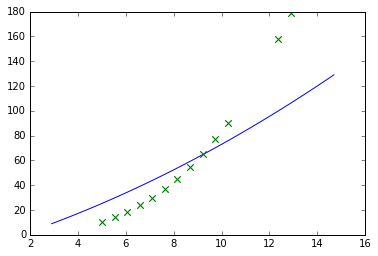

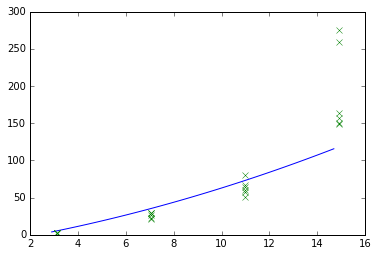

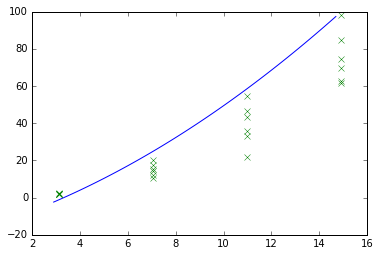

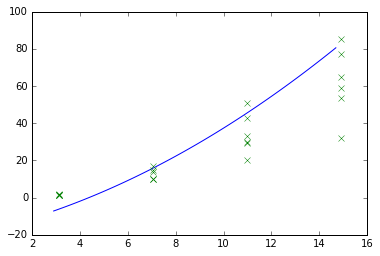

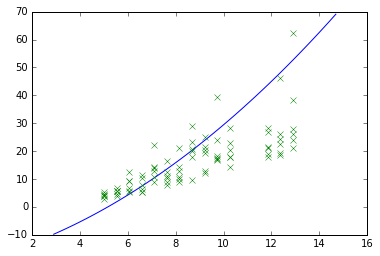

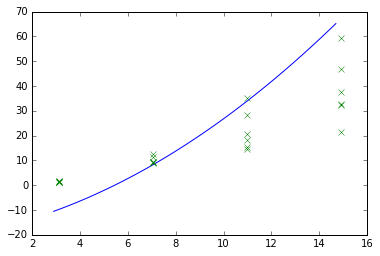

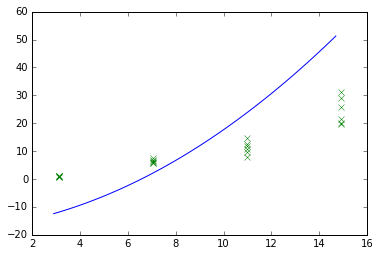

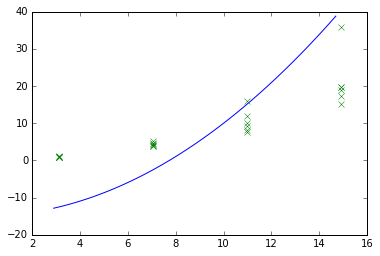

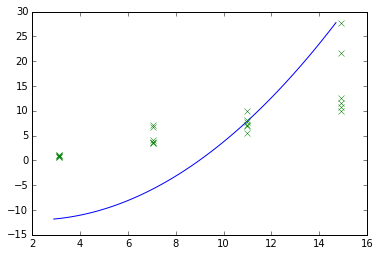

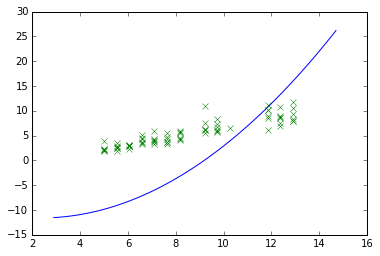

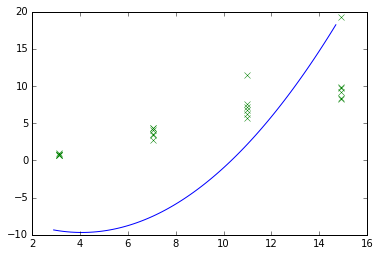

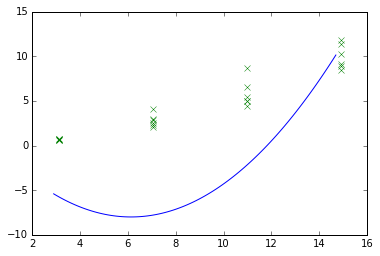

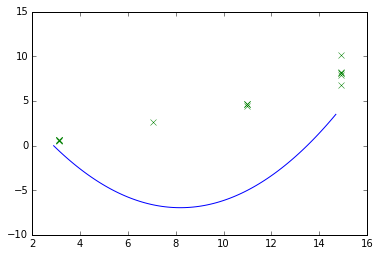

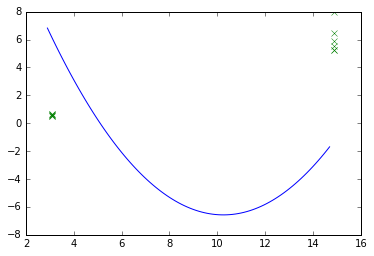

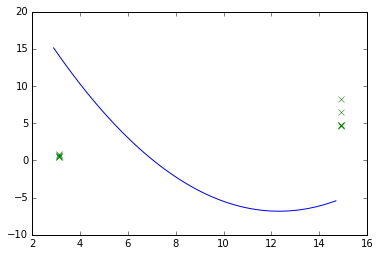

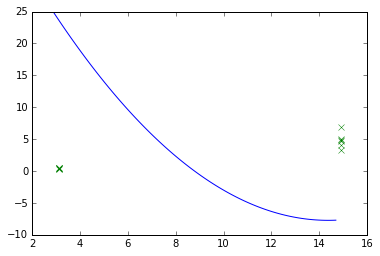

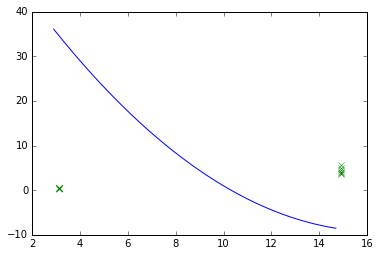

In [4]:
plt.close('all')
ns = sdb.Query('select distinct n from flowrun')
for n in ns: #np.linspace(0,max(ns),4):
    xx = np.zeros((100,2))
    strip = np.linspace(-0.5,0.5,100)
    yt = np.array(sdb.Query(
        'select h,v from flowrun where abs(n-({0}))<1.0e-7'.format(n[0])
    ))
    xx[:,0] = strip
    xx[:,1] = S.apply(np.array(n).reshape(-1,1),2)
    yy = Y_pred.eval(feed_dict={tf_x: xx}, session=sess)
    #plt.plot(strip,yy,'-')
    #plt.plot(S.apply(yt[:,0].reshape(-1,1),1),S.apply(yt[:,1].reshape(-1,1),3),'x')
    plt.figure()
    yy = S.invert(yy.reshape(-1,1),3)
    plt.plot(S.invert(strip.reshape(-1,1),1),yy,'-')
    plt.plot(yt[:,0],yt[:,1],'x')
    plt.show()